<a href="https://colab.research.google.com/github/PrithviRaajan/Semi-Supervised-LSTM-Autoencoder-with-Attention-for-Anomaly-Detection-in-Time-Series-Data/blob/main/preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import requests
import io

from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed,Input, Dropout, Dense, Attention
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
import seaborn as sns

In [ ]:
USE_GG_DRIVE = 0

if USE_GG_DRIVE:
  from goolge.colab import drive
  drive.mount('content\drive')

In [ ]:
url = '/content/drive/MyDrive/Colab Notebooks/MetroPT3(AirCompressor).csv'
df = pd.read_csv(url)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1516948 entries, 0 to 1516947
Data columns (total 17 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   Unnamed: 0       1516948 non-null  int64  
 1   timestamp        1516948 non-null  object 
 2   TP2              1516948 non-null  float64
 3   TP3              1516948 non-null  float64
 4   H1               1516948 non-null  float64
 5   DV_pressure      1516948 non-null  float64
 6   Reservoirs       1516948 non-null  float64
 7   Oil_temperature  1516948 non-null  float64
 8   Motor_current    1516948 non-null  float64
 9   COMP             1516948 non-null  float64
 10  DV_eletric       1516948 non-null  float64
 11  Towers           1516948 non-null  float64
 12  MPG              1516948 non-null  float64
 13  LPS              1516948 non-null  float64
 14  Pressure_switch  1516948 non-null  float64
 15  Oil_level        1516948 non-null  float64
 16  Caudal_impulses  1

### Preprocessing and EDA

In [ ]:
df.drop('Unnamed: 0', axis=1)

,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
0,2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1,2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2,2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
3,2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
4,2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1516943,2020-09-01 03:59:10,-0.014,8.918,8.906,-0.022,8.918,59.675,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1516944,2020-09-01 03:59:20,-0.014,8.904,8.888,-0.020,8.904,59.600,0.0450,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1516945,2020-09-01 03:59:30,-0.014,8.890,8.876,-0.022,8.892,59.600,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
1516946,2020-09-01 03:59:40,-0.012,8.876,8.864,-0.022,8.878,59.550,0.0450,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


In [ ]:
import datetime

#Check the current type of timestamp
print(f"Current type of timestamp is {type(df.timestamp[0])}")

#Convert timestamp to pandas.DateTime
df['timestamp'] = df['timestamp'].apply(pd.to_datetime, format = "%Y-%m-%d %H:%M:%S")

#Re-check the type
print(f"Current type of timestamp is {type(df.timestamp[0])}")

Current type of timestamp is <class 'str'>
Current type of timestamp is <class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [ ]:
labeled_data = df.copy()
labeled_data['status'] = 0
print(labeled_data.head(5))

   Unnamed: 0           timestamp    TP2    TP3     H1  DV_pressure  \
0           0 2020-02-01 00:00:00 -0.012  9.358  9.340       -0.024   
1          10 2020-02-01 00:00:10 -0.014  9.348  9.332       -0.022   
2          20 2020-02-01 00:00:19 -0.012  9.338  9.322       -0.022   
3          30 2020-02-01 00:00:29 -0.012  9.328  9.312       -0.022   
4          40 2020-02-01 00:00:39 -0.012  9.318  9.302       -0.022   

   Reservoirs  Oil_temperature  Motor_current  COMP  DV_eletric  Towers  MPG  \
0       9.358           53.600         0.0400   1.0         0.0     1.0  1.0   
1       9.348           53.675         0.0400   1.0         0.0     1.0  1.0   
2       9.338           53.600         0.0425   1.0         0.0     1.0  1.0   
3       9.328           53.425         0.0400   1.0         0.0     1.0  1.0   
4       9.318           53.475         0.0400   1.0         0.0     1.0  1.0   

   LPS  Pressure_switch  Oil_level  Caudal_impulses  status  
0  0.0              1.0       

In [ ]:
def to_datetime(xs):
  result = []
  format =  "%Y-%m-%d %H:%M:%S"
  for x in xs:
    result.append(pd.to_datetime(x, format = format))
  return result


failure_start_time = to_datetime(["2020-04-18 00:00:00", "2020-05-29 23:30:00", "2020-06-05 10:00:00", "2020-07-15 14:30:00"] )
failure_end_time   = to_datetime(["2020-04-18 23:59:00", "2020-05-30 06:00:00", "2020-06-07 14:30:00", "2020-07-15 19:00:00"] )

print(failure_start_time,"\n", failure_end_time[0].minute)

[Timestamp('2020-04-18 00:00:00'), Timestamp('2020-05-29 23:30:00'), Timestamp('2020-06-05 10:00:00'), Timestamp('2020-07-15 14:30:00')] 
 59


In [ ]:
def in_between(x, start, end):

  start_con = x >= start
  end_con = x<= end

  inbetween_con = start_con and end_con
  if inbetween_con:
    return 1
  else:
    return 0

In [ ]:
failure_indx = []

for i, (start_time, end_time) in enumerate(zip(failure_start_time, failure_end_time)):
  mask = labeled_data['timestamp'].apply(in_between, start = start_time, end = end_time)
  indx = labeled_data.index[mask == True].tolist()
  failure_indx += indx


print(f" Found {len(failure_indx)} samples representing failure state")

 Found 29954 samples representing failure state


In [ ]:
labeled_data['status'].iloc[failure_indx] = 1

<ipython-input-21-fcba6123af02>:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  labeled_data['status'].iloc[failure_indx] = 1
<ipython-input-21-fcba6123af02>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from 

In [ ]:
labeled_data['status'].iloc[failure_indx]

,status
562564,1
562565,1
562566,1
562567,1
562568,1
...,...
1172710,1
1172711,1
1172712,1
1172713,1


In [ ]:
#Seperate Positive samples and Negative sample
pos_data = labeled_data[labeled_data['status'] == 1]
neg_data = labeled_data[labeled_data['status'] == 0]

#Print out the info of 2 dataset
print(f"Positive dataset\n {pos_data.info()}\n")
print(f"Negative dataset\n {neg_data.info()}\n")

<class 'pandas.core.frame.DataFrame'>
Index: 29954 entries, 562564 to 1172714
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Unnamed: 0       29954 non-null  int64         
 1   timestamp        29954 non-null  datetime64[ns]
 2   TP2              29954 non-null  float64       
 3   TP3              29954 non-null  float64       
 4   H1               29954 non-null  float64       
 5   DV_pressure      29954 non-null  float64       
 6   Reservoirs       29954 non-null  float64       
 7   Oil_temperature  29954 non-null  float64       
 8   Motor_current    29954 non-null  float64       
 9   COMP             29954 non-null  float64       
 10  DV_eletric       29954 non-null  float64       
 11  Towers           29954 non-null  float64       
 12  MPG              29954 non-null  float64       
 13  LPS              29954 non-null  float64       
 14  Pressure_switch  29954 non-null  flo

In [ ]:
n_positives = int(pos_data['status'].count())
sub_neg_data = neg_data.sample(n_positives, random_state = 42)
print(f"Negative dataset after subsampling {sub_neg_data.info()}")

<class 'pandas.core.frame.DataFrame'>
Index: 29954 entries, 1306134 to 1276653
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Unnamed: 0       29954 non-null  int64         
 1   timestamp        29954 non-null  datetime64[ns]
 2   TP2              29954 non-null  float64       
 3   TP3              29954 non-null  float64       
 4   H1               29954 non-null  float64       
 5   DV_pressure      29954 non-null  float64       
 6   Reservoirs       29954 non-null  float64       
 7   Oil_temperature  29954 non-null  float64       
 8   Motor_current    29954 non-null  float64       
 9   COMP             29954 non-null  float64       
 10  DV_eletric       29954 non-null  float64       
 11  Towers           29954 non-null  float64       
 12  MPG              29954 non-null  float64       
 13  LPS              29954 non-null  float64       
 14  Pressure_switch  29954 non-null  fl

In [ ]:
merged_data = pd.concat([pos_data, sub_neg_data], axis = 0)
print(f"Merged dataset\n")
merged_data.info()

Merged dataset

<class 'pandas.core.frame.DataFrame'>
Index: 59908 entries, 562564 to 1276653
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Unnamed: 0       59908 non-null  int64         
 1   timestamp        59908 non-null  datetime64[ns]
 2   TP2              59908 non-null  float64       
 3   TP3              59908 non-null  float64       
 4   H1               59908 non-null  float64       
 5   DV_pressure      59908 non-null  float64       
 6   Reservoirs       59908 non-null  float64       
 7   Oil_temperature  59908 non-null  float64       
 8   Motor_current    59908 non-null  float64       
 9   COMP             59908 non-null  float64       
 10  DV_eletric       59908 non-null  float64       
 11  Towers           59908 non-null  float64       
 12  MPG              59908 non-null  float64       
 13  LPS              59908 non-null  float64       
 14  Pressure_switch  599

In [ ]:
def investigate_outliers(data, c):
    q1 = data[c].quantile(0.25)
    q3 = data[c].quantile(0.75)
    iqr = q3 - q1
    ll = q1 - 1.5*iqr
    ul = q3 + 1.5*iqr

    num_outliers = data[data[c] < ll][c].count()  + data[data[c] > ul][c].count()
    if num_outliers>0:
        print(f"Found {num_outliers} oulier(s) for feature {c}")
    return {'col': c, 'n_outliers': num_outliers, 'll': ll, 'ul': ul, 'q1': q1, 'q3':q3}

print("\nDropping outliers ...\n")
clean_data = merged_data.copy()
for i in range(5):
  for c in clean_data.columns:
      if c not in ["Unnamed: 0","timestamp"]:
          cue = investigate_outliers(clean_data, c)
          if cue["n_outliers"] > 0 and (cue["q1"]!= cue["q3"]):
              print(f"Droping {cue['n_outliers']} from column {c}")
              clean_data = clean_data[clean_data[c]> cue["ll"]]
              clean_data = clean_data[clean_data[c]< cue["ul"]]
              print(f"{clean_data.shape[0]} samples left\n")
          elif (cue["q1"]== cue["q3"]):
              print("Skipping .. data has Q1 equals to Q3")
              print(f"{clean_data.shape[0]} rows left\n")


print("\nDropping Completed ...\n")
#Recheck data
for c in clean_data.columns:
    if c not in ["Unnamed: 0","timestamp","COMP", 'status']:
        cue = investigate_outliers(clean_data, c)


Dropping outliers ...

Found 424 oulier(s) for feature TP3
Droping 424 from column TP3
59484 samples left

Found 5 oulier(s) for feature DV_pressure
Droping 5 from column DV_pressure
59479 samples left

Found 3 oulier(s) for feature Reservoirs
Droping 3 from column Reservoirs
59476 samples left

Found 29 oulier(s) for feature Oil_temperature
Droping 29 from column Oil_temperature
59447 samples left

Found 395 oulier(s) for feature LPS
Skipping .. data has Q1 equals to Q3
59447 rows left

Found 402 oulier(s) for feature Pressure_switch
Skipping .. data has Q1 equals to Q3
59447 rows left

Found 2897 oulier(s) for feature Oil_level
Skipping .. data has Q1 equals to Q3
59447 rows left

Found 1948 oulier(s) for feature Caudal_impulses
Skipping .. data has Q1 equals to Q3
59447 rows left

Found 2 oulier(s) for feature Oil_temperature
Droping 2 from column Oil_temperature
59445 samples left

Found 395 oulier(s) for feature LPS
Skipping .. data has Q1 equals to Q3
59445 rows left

Found 402 

<Axes: >

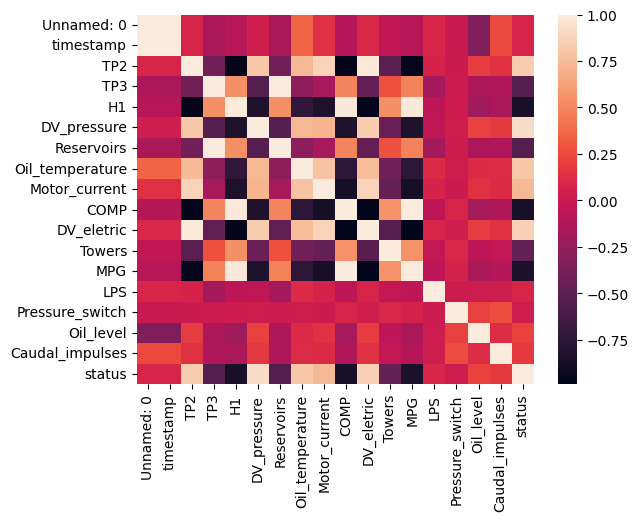

In [ ]:
clean_data.corr().round(2)
sns.heatmap(clean_data.corr().round(2),annot=False )

In [ ]:
output_file_name = "MetroPT3_clean_data.csv"
clean_data.to_csv(output_file_name, index=False)

print(f"Cleaned data has been successfully exported to {output_file_name}")

Cleaned data has been successfully exported to MetroPT3_clean_data.csv


### Model

In [ ]:
train_size = int(len(clean_data)*0.8)

train = clean_data[:train_size]
test = clean_data[train_size:]

print(train.shape)
print(test.shape)

(47556, 18)
(11889, 18)


In [ ]:
features = ['TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Oil_temperature',
                     'Motor_current', 'COMP', 'DV_eletric', 'Towers', 'MPG',
                     'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses']
sequence_len = 50

def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i + sequence_length]
        sequences.append(seq)
    return np.array(sequences)


train_sequences = create_sequences(train[features].values, sequence_len)
test_sequences = create_sequences(test[features].values, sequence_len)

shape = train_sequences.shape

array([[[ 8.248e+00,  8.238e+00, -2.400e-02, ...,  1.000e+00,
          1.000e+00,  1.000e+00],
        [ 8.248e+00,  8.238e+00, -2.400e-02, ...,  1.000e+00,
          1.000e+00,  1.000e+00],
        [ 8.248e+00,  8.238e+00, -2.400e-02, ...,  1.000e+00,
          1.000e+00,  1.000e+00],
        ...,
        [ 8.248e+00,  8.238e+00, -2.400e-02, ...,  1.000e+00,
          1.000e+00,  1.000e+00],
        [ 8.248e+00,  8.238e+00, -2.400e-02, ...,  0.000e+00,
          0.000e+00,  0.000e+00],
        [ 8.248e+00,  8.238e+00, -2.400e-02, ...,  1.000e+00,
          1.000e+00,  1.000e+00]],

       [[ 8.248e+00,  8.238e+00, -2.400e-02, ...,  1.000e+00,
          1.000e+00,  1.000e+00],
        [ 8.248e+00,  8.238e+00, -2.400e-02, ...,  1.000e+00,
          1.000e+00,  1.000e+00],
        [ 8.248e+00,  8.238e+00, -2.400e-02, ...,  0.000e+00,
          0.000e+00,  0.000e+00],
        ...,
        [ 8.248e+00,  8.238e+00, -2.400e-02, ...,  0.000e+00,
          0.000e+00,  0.000e+00],
        [ 8.